# Regression Modeling: Wanderdauer-Vorhersage - Schweizer Wanderwege

Dieses Notebook implementiert Regressionsmodelle zur Vorhersage der Wanderdauer basierend auf verschiedenen Wanderweg-Eigenschaften.

**Projektziel:** Erfüllung von Anforderung (5): "Use of regression as the modeling method"

**Fragestellung:** *"Wie lange dauert eine Wanderung basierend auf Distanz, Höhenprofil, Schwierigkeit und geografischer Lage?"*


## 1. Setup & Daten laden


In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from db_utils import read_from_db, setup_display_settings, setup_visualization_settings

setup_display_settings(float_format='{:.2f}', precision=3)
setup_visualization_settings()
print("Libraries erfolgreich importiert")


Display settings configured
Visualization settings configured
Libraries erfolgreich importiert


In [132]:
df = read_from_db("SELECT * FROM wanderwege")
df.head()


Loaded 375 rows, 13 columns from database


,url,title,location,canton,difficulty_level,difficulty_num,duration_min,distance_km,ascent_m,descent_m,physical_demand,latitude,longitude
0,https://www.schweizer-wanderwege.ch/de/wanderv...,Husky-Traum,Muotathal,None,None,NaN,NaN,0.00,NaN,NaN,hoch,46.97,8.77
1,https://www.schweizer-wanderwege.ch/de/wanderv...,Aufregende Ausblicke auf dem Hochalp Trail,"Urnäsch, Anker",AR,None,NaN,405.00,11.40,720.00,720.00,hoch,47.31,9.28
2,https://www.schweizer-wanderwege.ch/de/wanderv...,Den ganzen Tag im Schnee,"Atzmännig SSA — Atzmännig, Schutt",SG,None,NaN,100.00,4.20,140.00,510.00,mittel,NaN,NaN
3,https://www.schweizer-wanderwege.ch/de/wanderv...,Panorama Trail in Obwalden,Langis,OW,None,NaN,270.00,12.30,565.00,565.00,hoch,46.89,8.13
4,https://www.schweizer-wanderwege.ch/de/wanderv...,Schneeschuhwanderung auf den Chasseron,"Les Rasses, village",VD,None,NaN,260.00,10.00,450.00,450.00,hoch,46.83,6.55


## 2. Daten für Modeling vorbereiten


In [133]:
print("="*80)
print("FEATURE SELECTION FÜR MODELING")
print("="*80)

df_model = df.dropna(subset=['duration_min', 'distance_km', 'ascent_m', 'descent_m', 'difficulty_num']).copy()
print(f"\nDatensätze nach Bereinigung: {len(df_model)} (von {len(df)} ursprünglich)")

features = ['distance_km', 'ascent_m', 'descent_m', 'difficulty_num']
X = df_model[features].copy()
y = df_model['duration_min'].copy()
X = X.fillna(X.median())

print(f"\nAusgewählte Features ({len(features)}): {features}")
print(f"Feature Matrix: {X.shape}, Target Variable: {y.shape}")
print(f"\nTarget Statistik: Mean={y.mean():.1f}, Median={y.median():.1f}, Std={y.std():.1f}, Min={y.min():.1f}, Max={y.max():.1f} Minuten")


FEATURE SELECTION FÜR MODELING

Datensätze nach Bereinigung: 101 (von 375 ursprünglich)

Ausgewählte Features (4): ['distance_km', 'ascent_m', 'descent_m', 'difficulty_num']
Feature Matrix: (101, 4), Target Variable: (101,)

Target Statistik: Mean=180.4, Median=180.0, Std=56.0, Min=60.0, Max=350.0 Minuten


## 3. Train-Test Split


In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("="*80)
print("TRAIN-TEST SPLIT")
print("="*80)
print(f"\nTraining: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%), Test: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"Training - Mean: {y_train.mean():.1f} min, Test - Mean: {y_test.mean():.1f} min")


TRAIN-TEST SPLIT

Training: 80 samples (79.2%), Test: 21 samples (20.8%)
Training - Mean: 180.9 min, Test - Mean: 178.3 min


## 4. Model 1: Linear Regression (OLS)


In [135]:
print("="*80)
print("MODEL 1: LINEAR REGRESSION")
print("="*80)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)

print(f"\nPerformance Metrics:")
print(f"Training R²:  {train_r2_lr:.4f}, Test R²: {test_r2_lr:.4f}")
print(f"Training RMSE: {train_rmse_lr:.2f}, Test RMSE: {test_rmse_lr:.2f}, Test MAE: {test_mae_lr:.2f} Minuten")


MODEL 1: LINEAR REGRESSION

Performance Metrics:
Training R²:  0.9808, Test R²: 0.9818
Training RMSE: 7.76, Test RMSE: 7.35, Test MAE: 5.66 Minuten


In [136]:
print("\n" + "="*80)
print("LINEAR REGRESSION COEFFICIENTS")
print("="*80)

coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print(f"\nIntercept: {lr_model.intercept_:.2f} Minuten")
print("\nFeature Coefficients:")
print(coef_df[['Feature', 'Coefficient']].to_string(index=False))

print("\nINTERPRETATION:")
print(f"- Intercept: {lr_model.intercept_:.0f} min (Basis-Wanderzeit)")
for idx, row in coef_df.head(3).iterrows():
    if 'distance' in row['Feature']:
        print(f"- {row['Feature']}: +{row['Coefficient']:.2f} min pro km")
    elif 'ascent' in row['Feature'] or 'descent' in row['Feature']:
        print(f"- {row['Feature']}: +{row['Coefficient']:.2f} min pro Meter")
    elif 'difficulty' in row['Feature']:
        print(f"- {row['Feature']}: +{row['Coefficient']:.2f} min pro Schwierigkeitsstufe")



LINEAR REGRESSION COEFFICIENTS

Intercept: -2.57 Minuten

Feature Coefficients:
       Feature  Coefficient
   distance_km        13.52
difficulty_num         0.70
      ascent_m         0.09
     descent_m         0.03

INTERPRETATION:
- Intercept: -3 min (Basis-Wanderzeit)
- distance_km: +13.52 min pro km
- difficulty_num: +0.70 min pro Schwierigkeitsstufe
- ascent_m: +0.09 min pro Meter


## 5. Model 2: Random Forest Regression


### 5.1 Hyperparameter Tuning: max_depth Optimierung


In [137]:
print("="*80)
print("RANDOM FOREST: max_depth Optimierung")
print("="*80)

max_depths = [3, 5, 10, 15, None]
rf_results = []

for depth in max_depths:
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=depth, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)

    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    rf_results.append({
        'max_depth': depth,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'overfitting': train_r2 - test_r2
    })

    depth_str = str(depth) if depth else "None"
    print(f"\nmax_depth = {depth_str:>4}")
    print(f"Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f} | Differenz: {train_r2-test_r2:.4f}")
    print(f"Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}")

rf_results_df = pd.DataFrame(rf_results)

print("\n" + "="*80)
print("ZUSAMMENFASSUNG - Random Forest max_depth Vergleich")
print("="*80)
print(rf_results_df.to_string(index=False))

best_idx = rf_results_df['test_r2'].idxmax()
best_depth = rf_results_df.iloc[best_idx]['max_depth']
print(f"\nBester max_depth Wert: {best_depth} (Test R² = {rf_results_df.iloc[best_idx]['test_r2']:.4f})")


RANDOM FOREST: max_depth Optimierung

max_depth =    3
Train R²: 0.9564 | Test R²: 0.9340 | Differenz: 0.0224
Train RMSE: 11.69 | Test RMSE: 14.02

max_depth =    5
Train R²: 0.9869 | Test R²: 0.9573 | Differenz: 0.0296
Train RMSE: 6.40 | Test RMSE: 11.28

max_depth =   10
Train R²: 0.9902 | Test R²: 0.9528 | Differenz: 0.0374
Train RMSE: 5.53 | Test RMSE: 11.86

max_depth =   15
Train R²: 0.9903 | Test R²: 0.9533 | Differenz: 0.0369
Train RMSE: 5.52 | Test RMSE: 11.79

max_depth = None
Train R²: 0.9903 | Test R²: 0.9533 | Differenz: 0.0369
Train RMSE: 5.52 | Test RMSE: 11.79

ZUSAMMENFASSUNG - Random Forest max_depth Vergleich
 max_depth  train_r2  test_r2  train_rmse  test_rmse  overfitting
      3.00      0.96     0.93       11.69      14.02         0.02
      5.00      0.99     0.96        6.40      11.28         0.03
     10.00      0.99     0.95        5.53      11.86         0.04
     15.00      0.99     0.95        5.52      11.79         0.04
       NaN      0.99     0.95     

### 5.2 Finales Random Forest Modell


In [138]:
optimal_depth = 5
rf_final = RandomForestRegressor(n_estimators=100, max_depth=optimal_depth, random_state=42, n_jobs=-1)
rf_final.fit(X_train, y_train)

y_train_pred_rf = rf_final.predict(X_train)
y_test_pred_rf = rf_final.predict(X_test)

train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)

print("="*80)
print("FINALES MODELL: RANDOM FOREST REGRESSION")
print("="*80)
print(f"\nKonfiguration: n_estimators=100, max_depth={optimal_depth}, random_state=42")
print("\nPerformance Metrics:")
print(f"Training R²: {train_r2_rf:.4f}, Test R²: {test_r2_rf:.4f}")
print(f"Training RMSE: {train_rmse_rf:.2f}, Test RMSE: {test_rmse_rf:.2f}, Test MAE: {test_mae_rf:.2f} Minuten")


FINALES MODELL: RANDOM FOREST REGRESSION

Konfiguration: n_estimators=100, max_depth=5, random_state=42

Performance Metrics:
Training R²: 0.9869, Test R²: 0.9573
Training RMSE: 6.40, Test RMSE: 11.28, Test MAE: 8.00 Minuten



FEATURE IMPORTANCE ANALYSE

Feature Importance Ranking:
       Feature  Importance
   distance_km        0.88
      ascent_m        0.07
     descent_m        0.05
difficulty_num        0.00


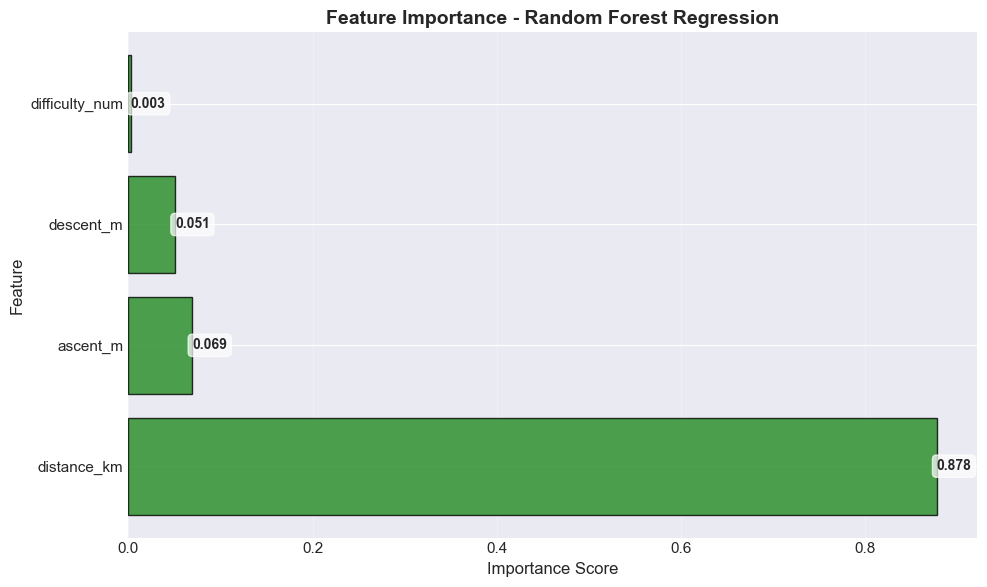


INTERPRETATION:
- Wichtigstes Feature: distance_km (0.878)
- Dies bedeutet: distance_km hat den grössten Einfluss auf die Wanderdauer


In [139]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSE")
print("="*80)

feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_final.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance Ranking:")
print(feature_importance.to_string(index=False))

plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'],
                color='forestgreen', edgecolor='black', alpha=0.8)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance - Random Forest Regression', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
for bar, value in zip(bars, feature_importance['Importance']):
    plt.text(value, bar.get_y() + bar.get_height()/2, f'{value:.3f}',
             va='center', ha='left', fontweight='bold', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
plt.tight_layout()
plt.show()

top_feature = feature_importance.iloc[0]
print(f"\nINTERPRETATION:")
print(f"- Wichtigstes Feature: {top_feature['Feature']} ({top_feature['Importance']:.3f})")
print(f"- Dies bedeutet: {top_feature['Feature']} hat den grössten Einfluss auf die Wanderdauer")


## 6. Daten für nächstes Notebook speichern


In [140]:
print("="*80)
print("DATEN FÜR MR_06 SPEICHERN")
print("="*80)

%store X_train
%store X_test
%store y_train
%store y_test
%store features
%store lr_model
%store y_train_pred_lr
%store y_test_pred_lr
%store train_r2_lr
%store test_r2_lr
%store train_rmse_lr
%store test_rmse_lr
%store test_mae_lr
%store rf_final
%store y_train_pred_rf
%store y_test_pred_rf
%store train_r2_rf
%store test_r2_rf
%store train_rmse_rf
%store test_rmse_rf
%store test_mae_rf
%store rf_results_df
%store max_depths

print("\nAlle Daten gespeichert für MR_06_model_evaluation.ipynb")


DATEN FÜR MR_06 SPEICHERN
Stored 'X_train' (DataFrame)
Stored 'X_test' (DataFrame)
Stored 'y_train' (Series)
Stored 'y_test' (Series)
Stored 'features' (list)
Stored 'lr_model' (LinearRegression)
Stored 'y_train_pred_lr' (ndarray)
Stored 'y_test_pred_lr' (ndarray)
Stored 'train_r2_lr' (float)
Stored 'test_r2_lr' (float)
Stored 'train_rmse_lr' (float64)
Stored 'test_rmse_lr' (float64)
Stored 'test_mae_lr' (float)
Stored 'rf_final' (RandomForestRegressor)
Stored 'y_train_pred_rf' (ndarray)
Stored 'y_test_pred_rf' (ndarray)
Stored 'train_r2_rf' (float)
Stored 'test_r2_rf' (float)
Stored 'train_rmse_rf' (float64)
Stored 'test_rmse_rf' (float64)
Stored 'test_mae_rf' (float)
Stored 'rf_results_df' (DataFrame)
Stored 'max_depths' (list)

Alle Daten gespeichert für MR_06_model_evaluation.ipynb


## 7. Zusammenfassung


In [141]:
print("="*80)
print("ZUSAMMENFASSUNG - MODELLE TRAINIERT")
print("="*80)
print(f"Linear Regression: Test R²={test_r2_lr:.4f}, Test RMSE={test_rmse_lr:.2f} min")
print(f"Random Forest (max_depth=5): Test R²={test_r2_rf:.4f}, Test RMSE={test_rmse_rf:.2f} min")
print("Beide Modelle erfolgreich trainiert und bereit für Evaluation")
print("Weiter mit MR_06_model_evaluation.ipynb für detaillierte Evaluation")


ZUSAMMENFASSUNG - MODELLE TRAINIERT
Linear Regression: Test R²=0.9818, Test RMSE=7.35 min
Random Forest (max_depth=5): Test R²=0.9573, Test RMSE=11.28 min
Beide Modelle erfolgreich trainiert und bereit für Evaluation
Weiter mit MR_06_model_evaluation.ipynb für detaillierte Evaluation
